<a href="https://colab.research.google.com/github/yohanesnuwara/pyMRST/blob/main/pyMRST_oilwaterflooding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of Waterflooding in Oil Reservoir with PyMRST

The aim of this notebook is to run MRST simulation of waterflooding (written in MATLAB language) in Python environment with PyMRST. PyMRST allows users to define simulation input, run simulation, and visualize results using Python syntaxes. 

## Setup

PyMRST is in GitHub. We need to clone the repository to use it. 

In [1]:
# Clone pyMRST
!git clone https://github.com/yohanesnuwara/pyMRST

Cloning into 'pyMRST'...
remote: Enumerating objects: 256, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 256 (delta 61), reused 0 (delta 0), pack-reused 132
Receiving objects: 100% (256/256), 278.45 KiB | 8.70 MiB/s, done.
Resolving deltas: 100% (107/107), done.


Import necessary Python libraries (NumPy, Matplotlib) and PyMRST modules. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Add directory where you install PyMRST
import sys
sys.path.append("/content/pyMRST") 

import pymrst
from pymrst_units import *

Setup PyMRST. The setup will do installation of MATLAB-Octave in Google Colab and cloning the original MRST repositories in their BitBucket.  

In [3]:
# Setup PyMRST (Takes about 1 minute)
pymrst.setup()

Now, we can start using Python syntaxes to run MRST. All set!

## Simulation 1. Normal five spot

In the first simulation, we will use the SPE 10 reservoir model. The model is available in MRST (more details about this model [see here](https://www.spe.org/web/csp/datasets/set02.htm)). The original cells are 60x220x85, we will only use the 10-th first layers.

In [4]:
# Use SPE10 model. Use Python dictionary.
model = dict({"name": "spe10",
              "nlayer": 10, 
              "startlayer": 4})       

Input rock properties. The reservoir is assumed to have formation compressibility 1 micro-Bar (measured at 200 bar as reference pressure). 

In [5]:
# Rock property
rock = dict({"c": 1e-6*(1/1e+5), # Rock compressibility at ref pressure, 1/bar to 1/Pa
             "p_r": 200*1e+5}) # Reference pressure, bar to Pa

The fluids that we will use are slightly compressible oil (as producer fluid) and incompressible water (as injector fluid). Oil has 1 cp viscosity and 850 kg/m3 density. Water has 1 cp viscosity and 1,000 kg/m3 density. Corey relative permeability model with exponent 2 is used. 

> NOTE: If we use a non-metric unit, use the units inside `pymrst_units`. For example, define 1 cp as `1*centi()*poise()`. It is because MRST runs simulation based on [metric units](https://en.wikipedia.org/wiki/Metric_units). Notice that the syntax is just very similar to MRST. 

In [6]:
# Fluid property: 2-phase oil-water
fluid = dict({"type": ["water", "oil"],
              "mu": [1*centi()*poise(), 1*centi()*poise()],
              "rho": [1000, 850],
              "n": [2, 2]}) # Corey exponent

Input boundary conditions for front side (North), back side (South), left side (West), and right side (East). All boundaries have no flow. 

> NOTE: For now, PyMRST still support for no-flow boundary condition. 

In [7]:
# Boundary 
bc_front = dict({"type": "fluxside", "value": 0}) # bbl/d to m3/s
bc_back = dict({"type": "fluxside", "value": 0})
bc_left = dict({"type": "fluxside", "value": 0}) # m3/d to m3/s
bc_right = dict({"type": "pside", "value": 0}) # bar to Pa

Input well operating conditions. Since it is normal five spot, there are 5 wells; 4 water injectors in the corners and 1 oil producer in the middle. All wells are vertical wells. Here are the details of the wells;

|Well|Status|Cell location|BC|Radii|Skin|
|:--:|:--:|:--:|:--:|:--:|:--:|
|I|Water injector|(1,1)|BHP 200 bar|.125 m|0|
|II|Water injector|(60,1)|BHP 200 bar|.125 m|0|
|III|Water injector|(1,220)|BHP 200 bar|.125 m|0|
|IV|Water injector|(60,220)|BHP 200 bar|.125 m|0|
|V|Oil producer|(30,111)|BHP 100 bar|.125 m|0|

> NOTE: Phase convention is [water,oil]. Because Well I to IV are water injectors, phase is [1,0]. Then Well V is oil producer, phase is [0,1].

In [8]:
# Well
locs = np.array([[1,  60, 1,    60,   30],
                 [1,  1,  220,  220,  111],
                 [1,  1,  1,    1,    1]])

types = np.full(5, "bhp")
values = np.array([200, 200, 200, 200, 100])*barsa()
radii = np.full(5, .125)*meter()
skins = np.full(5, 0)
directions = np.full(5, None) # Vertical well is None
phases = np.array([[1,0], [1,0], [1,0], [1,0], [0,1]])

well = dict({"cellx_loc": locs[0,:],
             "celly_loc": locs[1,:], 
             "cellz_loc": locs[2,:],              
             "type": types, 
             "value": values, 
             "phase": phases,
             "radius": radii,
             "skin": skins, 
             "direction": directions}) 

Define how long the reservoir is simulated (here 20 years) in 50 time steps. We will evaluate results at year 2, 10, 20, and 50. 

In [10]:
# Time step
numSteps, totTime = 50, 20*365 # 20 years
steps = [2, 10, 20, 50]

Execute program to read the inputs. 

In [11]:
# Run program to read input
pymrst.model_input(model, fluid, well, bc_front, bc_back, bc_left, bc_right, 
                   numSteps, totTime, steps) 

Finally run the simulation. 

In [12]:
# Takes 5 minutes to complete simulation. Depends on internet connection.
pymrst.oilwater_2phase()

Time step 1: 1.00 years
Time step 2: 1.39 years
Time step 3: 1.77 years
Time step 4: 2.16 years
Time step 5: 2.55 years
Time step 6: 2.94 years
Time step 7: 3.32 years
Time step 8: 3.71 years
Time step 9: 4.10 years
Time step 10: 4.49 years
Time step 11: 4.87 years
Time step 12: 5.26 years
Time step 13: 5.65 years
Time step 14: 6.04 years
Time step 15: 6.42 years
Time step 16: 6.81 years
Time step 17: 7.20 years
Time step 18: 7.59 years
Time step 19: 7.97 years
Time step 20: 8.36 years
Time step 21: 8.75 years
Time step 22: 9.14 years
Time step 23: 9.52 years
Time step 24: 9.91 years
Time step 25: 10.30 years
Time step 26: 10.69 years
Time step 27: 11.07 years
Time step 28: 11.46 years
Time step 29: 11.85 years
Time step 30: 12.24 years
Time step 31: 12.62 years
Time step 32: 13.01 years
Time step 33: 13.40 years
Time step 34: 13.79 years
Time step 35: 14.17 years
Time step 36: 14.56 years
Time step 37: 14.95 years
Time step 38: 15.34 years
Time step 39: 15.72 years
Time step 40: 16.11

Running simulation has finished. Note that all results are stored automatically inside `result_oilwater_2phase` folder.
* `Sw{}.mat`: Water saturation in reservoir. Number inside bracket is year.
* `pressure{}.mat`: Pressure in reservoir. Number inside bracket is year.
* `well{}_Sw.mat`, `well{}_Wc.mat`, `well{}_qOs.mat`, `well{}_qWs.mat`: Water saturation, water cut, oil saturation, and water saturation (respectively) at each well over the years. Number inside bracket is well number.    

In this case, the simulated years are year 2, 10, 20, and 50.

First, visualize the reservoir water saturation. It can do 2D visualization (for this time). 

Define which side we want to visualize; XY, XZ, or YZ plane, and the position (layer number). Here, we want the first layer (position-0) of XY plane.  

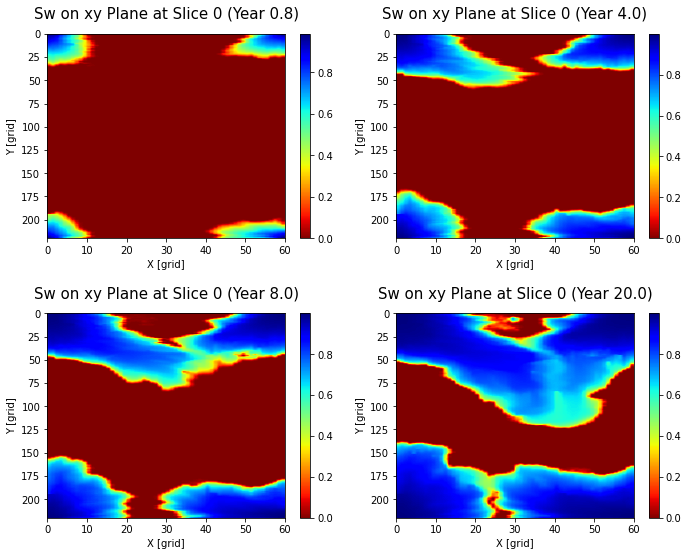

In [13]:
from pymrst_units import *

# Specify dimension
nlayer = model["nlayer"]
dimension = (60,220,nlayer)

# Plane and layer number
plane, position = "xy", 0

numSteps, totTime = 50, 20*365 # day
steps = [2, 10, 20, 50]

# Plot Sw for every timestep
plt.figure(figsize=(10,8))

for i in range(len(steps)):
  directory = "/content/result_oilwater_2phase/"
  filename = "Sw{}.mat".format(steps[i])

  # Get cell data 
  cube = pymrst.getCellData(directory, filename, dimension=dimension)

  # Plot for every timestep
  days = totTime / numSteps * steps[i]
  years = days * day() / year()

  plt.subplot(2,2,i+1)
  pymrst.plotCellData(cube, plane, position, cmap="jet_r")
  plt.title("Sw on {} Plane at Slice {} (Year {:.1f})".format(plane, position, years),
            size=15, pad=15)  

plt.tight_layout(1.7)
plt.show()

Next is reservoir pressure. The same plane and layer number visualized. 

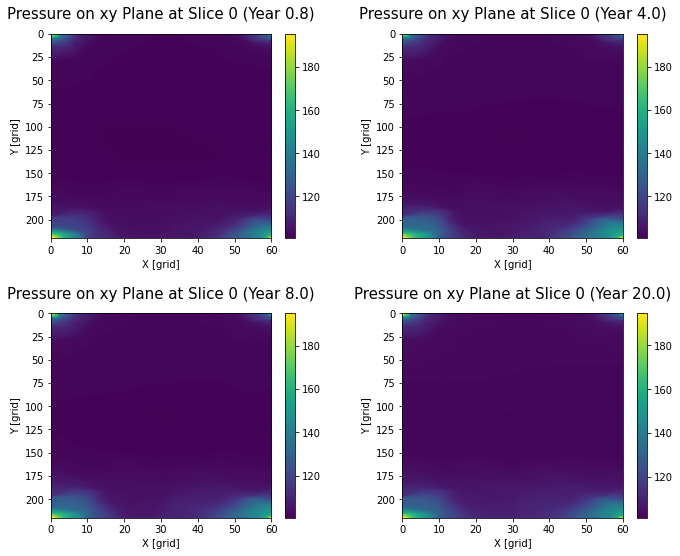

In [ ]:
from pymrst_units import *

# Specify dimension
nlayer = model["nlayer"]
dimension = (60,220,nlayer)

# Plane and layer number
plane, position = "xy", 0

numSteps, totTime = 50, 20*365 # day
steps = [2, 10, 20, 50]

# Plot pressure for every timestep
plt.figure(figsize=(10,8))

for i in range(len(steps)):
  directory = "/content/result_oilwater_2phase/"
  filename = "pressure{}.mat".format(steps[i])

  # Get cell data 
  cube = pymrst.getCellData(directory, filename, dimension=dimension)

  # Convert to barsa
  cube = cube/barsa()

  # Plot for every timestep
  days = totTime / numSteps * steps[i]
  years = days * day() / year()

  plt.subplot(2,2,i+1)
  pymrst.plotCellData(cube, plane, position, cmap="viridis")
  plt.title("Pressure on {} Plane at Slice {} (Year {:.1f})".format(plane, position, years),
            size=15, pad=15)  

plt.tight_layout(1.7)
plt.show()

## Simulation 2. Inverted five spot

In the second simulation, we simulate on the same reservoir as the first one, but now the injection pattern is inverted; 4 oil producers in the corner and 1 water injector in the middle. 

We will use the same rock, fluid, timestep, and boundary conditions input. We only need to slightly change the inputs for well. 

BHP for Well V is now 500 bar (because it is injector), instead of 100 bar like in Simulation 1.

|Well|Status|Cell location|BC|Radii|Skin|
|:--:|:--:|:--:|:--:|:--:|:--:|
|I|Oil producer|(1,1)|BHP 200 bar|.125 m|0|
|II|Oil producer|(60,1)|BHP 200 bar|.125 m|0|
|III|Oil producer|(1,220)|BHP 200 bar|.125 m|0|
|IV|Oil producer|(60,220)|BHP 200 bar|.125 m|0|
|V|Water injector|(30,111)|BHP 500 bar|.125 m|0|

> NOTE: Don't forget to change the phase, because now it is inverted. Well I to IV phase are [0,1] and Well V phase is [1,0]

In [14]:
# Well
locs = np.array([[1,  60, 1,    60,   30],
                 [1,  1,  220,  220,  111],
                 [1,  1,  1,    1,    1]])

types = np.full(5, "bhp")
values = np.array([200, 200, 200, 200, 500])*barsa()
radii = np.full(5, .125)*meter()
skins = np.full(5, 0)
directions = np.full(5, None)
phases = np.array([[0,1], [0,1], [0,1], [0,1], [1,0]])

well = dict({"cellx_loc": locs[0,:],
             "celly_loc": locs[1,:], 
             "cellz_loc": locs[2,:],              
             "type": types, 
             "value": values, 
             "phase": phases,
             "radius": radii,
             "skin": skins, 
             "direction": directions}) 

In [27]:
# Time step
numSteps, totTime = 50, 20*365 # 20 years
steps = [2, 10, 20, 50]
steps = list(np.arange(1,51,1))

Execute the program to read the input.

In [28]:
# Execute program to read input
pymrst.model_input(model, fluid, well, bc_front, bc_back, bc_left, bc_right, 
                   numSteps, totTime, steps) 

Run the simulation.

In [29]:
# Takes 5 minutes to complete simulation
pymrst.oilwater_2phase()

Time step 1: 1.00 years
Time step 2: 1.39 years
Time step 3: 1.77 years
Time step 4: 2.16 years
Time step 5: 2.55 years
Time step 6: 2.94 years
Time step 7: 3.32 years
Time step 8: 3.71 years
Time step 9: 4.10 years
Time step 10: 4.49 years
Time step 11: 4.87 years
Time step 12: 5.26 years
Time step 13: 5.65 years
Time step 14: 6.04 years
Time step 15: 6.42 years
Time step 16: 6.81 years
Time step 17: 7.20 years
Time step 18: 7.59 years
Time step 19: 7.97 years
Time step 20: 8.36 years
Time step 21: 8.75 years
Time step 22: 9.14 years
Time step 23: 9.52 years
Time step 24: 9.91 years
Time step 25: 10.30 years
Time step 26: 10.69 years
Time step 27: 11.07 years
Time step 28: 11.46 years
Time step 29: 11.85 years
Time step 30: 12.24 years
Time step 31: 12.62 years
Time step 32: 13.01 years
Time step 33: 13.40 years
Time step 34: 13.79 years
Time step 35: 14.17 years
Time step 36: 14.56 years
Time step 37: 14.95 years
Time step 38: 15.34 years
Time step 39: 15.72 years
Time step 40: 16.11

Visualize water saturation of the reservoir. 

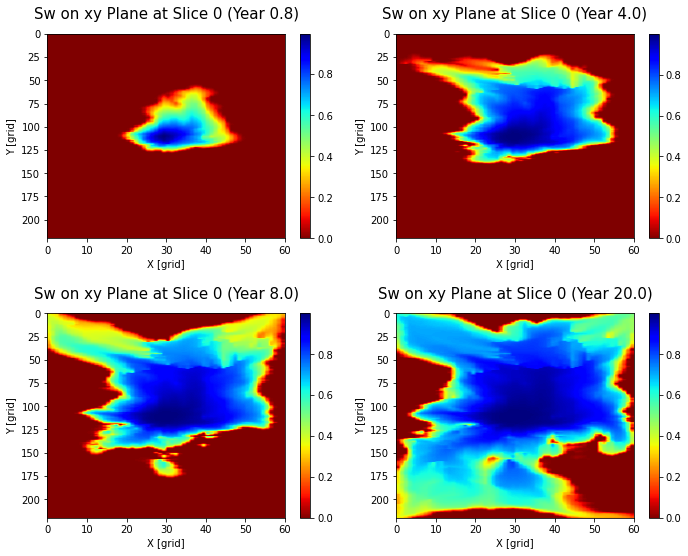

In [24]:
from pymrst_units import *

# Specify dimension
nlayer = model["nlayer"]
dimension = (60,220,nlayer)

# Plane and layer number
plane, position = "xy", 0

numSteps, totTime = 50, 20*365 # day
steps = [2, 10, 20, 50]

# Plot Sw for every timestep
plt.figure(figsize=(10,8))

for i in range(len(steps)):
  directory = "/content/result_oilwater_2phase/"
  filename = "Sw{}.mat".format(steps[i])

  # Get cell data 
  cube = pymrst.getCellData(directory, filename, dimension=dimension)

  # Plot for every timestep
  days = totTime / numSteps * steps[i]
  years = days * day() / year()

  plt.subplot(2,2,i+1)
  pymrst.plotCellData(cube, plane, position, cmap="jet_r")
  plt.title("Sw on {} Plane at Slice {} (Year {:.1f})".format(plane, position, years),
            size=15, pad=15)  

plt.tight_layout(1.7)
plt.show()

Visualize reservoir pressure.

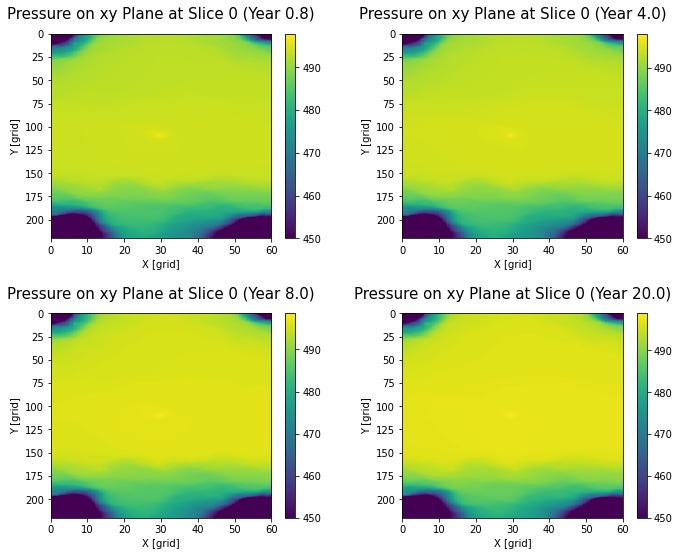

In [18]:
from pymrst_units import *

# Specify dimension
nlayer = model["nlayer"]
dimension = (60,220,nlayer)

# Plane and layer number
plane, position = "xy", 0

numSteps, totTime = 50, 20*365 # day
steps = [2, 10, 20, 50]

# Plot pressure for every timestep
plt.figure(figsize=(10,8))

for i in range(len(steps)):
  directory = "/content/result_oilwater_2phase/"
  filename = "pressure{}.mat".format(steps[i])

  # Get cell data 
  cube = pymrst.getCellData(directory, filename, dimension=dimension)

  # Convert to barsa
  cube = cube/barsa()

  # Plot for every timestep
  days = totTime / numSteps * steps[i]
  years = days * day() / year()

  plt.subplot(2,2,i+1)
  pymrst.plotCellData(cube, plane, position, cmap="viridis", vmin=450)
  plt.title("Pressure on {} Plane at Slice {} (Year {:.1f})".format(plane, position, years),
            size=15, pad=15)  

plt.tight_layout(1.7)
plt.show()

Last three visualizations are results for the 4 producer wells.

Water saturation and water cut

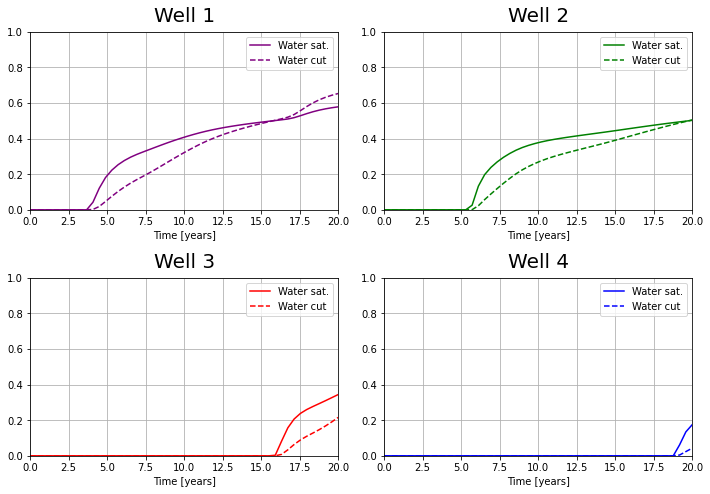

In [19]:
from pymrst_units import *

# Plot well solutions
directory = "/content/result_oilwater_2phase"

# Time entry
t = np.linspace(0, totTime, numSteps)
t = t*day()/year() # Convert from day to year

color = ["purple", "green", "red", "blue"]
plt.figure(figsize=(10,7))

for i in range(4):
  plt.subplot(2,2,i+1)
  well_Sw = pymrst.getWellSol(directory, "well{}_Sw.mat".format(i+1))
  well_Wc = pymrst.getWellSol(directory, "well{}_Wc.mat".format(i+1))  

  plt.plot(t, well_Sw, color=color[i], label="Water sat.")
  plt.plot(t, well_Wc, '--', color=color[i], label="Water cut")  

  plt.title("Well {}".format(i+1), size=20, pad=10)
  plt.xlabel("Time [years]")
  plt.xlim(0,20); plt.ylim(0,1)
  plt.grid()
  plt.legend()

plt.tight_layout(1.2)
plt.show()  

Water and oil production rate

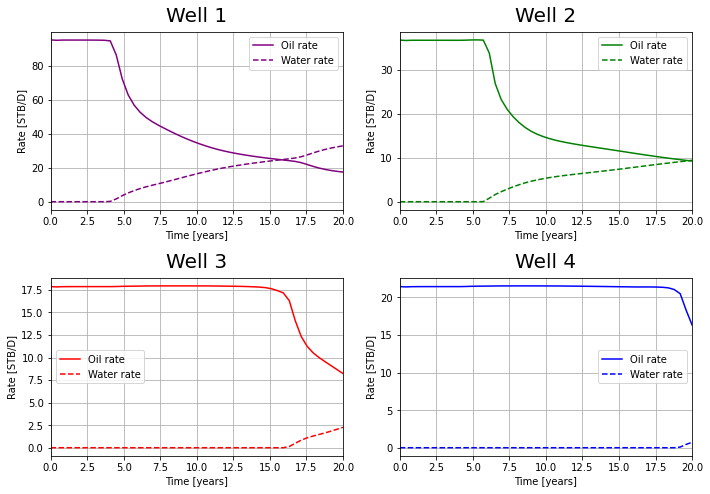

In [20]:
from pymrst_units import *

# Plot well solutions
directory = "/content/result_oilwater_2phase"

# Time entry
t = np.linspace(0, totTime, numSteps)
t = t*day()/year() # Convert from day to year

color = ["purple", "green", "red", "blue"]
plt.figure(figsize=(10,7))

for i in range(4):
  plt.subplot(2,2,i+1)
  well_qOs = pymrst.getWellSol(directory, "well{}_qOs.mat".format(i+1))
  well_qWs = pymrst.getWellSol(directory, "well{}_qWs.mat".format(i+1))  

  # Convert rates from m3/s to STB/D
  plt.plot(t, well_qOs/(stb()/day()), color=color[i], label="Oil rate")
  plt.plot(t, well_qWs/(stb()/day()), '--', color=color[i], label="Water rate")  

  plt.title("Well {}".format(i+1), size=20, pad=10)
  plt.xlabel("Time [years]"); plt.ylabel("Rate [STB/D]")
  plt.xlim(0,20)
  plt.grid()
  plt.legend()

plt.tight_layout(1.2)
plt.show()  

Water and oil cumulative production

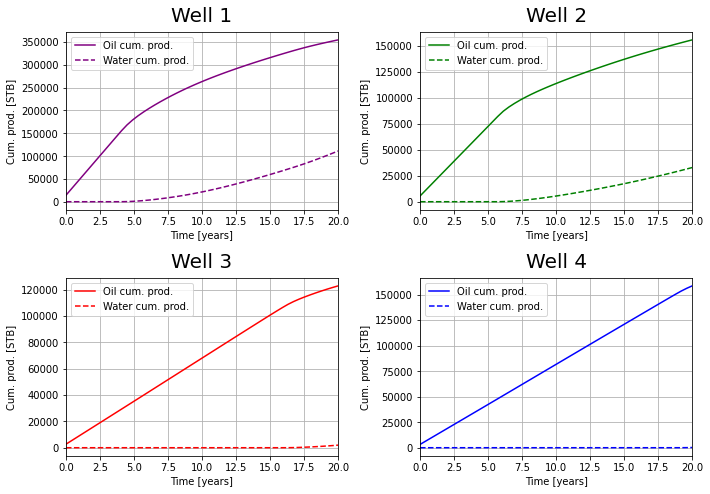

In [21]:
from pymrst_units import *

# Plot well solutions
directory = "/content/result_oilwater_2phase"

# Time entry
t = np.linspace(0, totTime, numSteps)
t = t*day()/year() # Convert from day to year

color = ["purple", "green", "red", "blue"]
plt.figure(figsize=(10,7))

for i in range(4):
  plt.subplot(2,2,i+1)
  well_qOs = pymrst.getWellSol(directory, "well{}_qOs.mat".format(i+1))
  well_qWs = pymrst.getWellSol(directory, "well{}_qWs.mat".format(i+1))  

  # Rate to cumulative production
  timestep = (t[1]-t[0])*year()
  cumO, cumW = well_qOs*timestep, well_qWs*timestep
  cumO, cumW = np.cumsum(cumO), np.cumsum(cumW)

  # Convert rates from m3 to STB
  plt.plot(t, cumO/stb(), color=color[i], label="Oil cum. prod.")
  plt.plot(t, cumW/stb(), '--', color=color[i], label="Water cum. prod.")  

  plt.title("Well {}".format(i+1), size=20, pad=10)
  plt.xlabel("Time [years]"); plt.ylabel("Cum. prod. [STB]")
  plt.xlim(0,20)
  plt.grid()
  plt.legend()

plt.tight_layout(1.2)
plt.show()  